In [178]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline


In [171]:
import ray
from ray import tune
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#start by making the grid - we want a 6x6 square


class GridWorld:
  
    def __init__(self):
        
        self.height = 6
        self.width = 6
        self.grid = np.zeros(( self.height, self.width)) - 1
        

#now we have a grid, we want our agent ot start in a random position each time

        self.current_position = ( 2, np.random.randint(0,6))
        
        
# our agent is allowed to move in 4 directions in this grid: up, down, left and right (no diagonal moves)
#agent can also only move one square at a time 
        self.actions = ['left', 'right', 'up', 'down']        

#some ppositions on the grid that have special meaning: the home, reards and the trap
#these are their co-ordinates 

        self.trap = (1,4)
        self.home = (0,4)
        self.reward_1 = (3,1)
        self.reward_2 = (4, 4)
        
#if the agent reaches either the trap or home the game is terminated 
        self.end_of_episode = [ self.trap, self.home]

    


#now we move on to defining methods so the agent can move:


#defining the agent's possible actions 
    def get_available_actions(self):
        return self.actions
    
    
#defines the reward the agent will get for moving to their new position   
    def get_reward(self, new_position):
        return self.grid[ new_position[0], new_position[1]]
        
        
#defining how the agent will take its next step, will move the agent in one of the four available directions 
#if agent is at the edge of the grid, it will not be able to move past the edge 
#agent can only move one square at a time 

    def move(self, action):
       
#agent remembers previous position

        prev_position = self.current_position
        
        if action == 'up':
            if prev_position[0] == 0:
                reward = self.get_reward(prev_position)
            else:
                self.current_position = ( self.current_position[0] - 1, self.current_position[1])
                reward = self.get_reward(self.current_position)
        
    
        elif action == 'down':
            if prev_position[0] == self.height - 1:
                reward = self.get_reward(prev_position)
            else:
                self.current_position = ( self.current_position[0] + 1, self.current_position[1])
                reward = self.get_reward(self.current_position)
            
       
        elif action == 'left':
            if prev_position[1] == 0:
                reward = self.get_reward(prev_position)
            else:
                self.current_position = ( self.current_position[0], self.current_position[1] - 1)
                reward = self.get_reward(self.current_position)

        
        elif action == 'right':
            if prev_position[1] == self.width - 1:
                reward = self.get_reward(prev_position)
            else:
                self.current_position = ( self.current_position[0], self.current_position[1] + 1)
                reward = self.get_reward(self.current_position)
                
        return reward
    
    
    
#if the agent has moved to either one of the two terminal states (home or trap, end the episode)
    def check_state(self):
        
        if self.current_position in self.end_of_episode:
            return 'TERMINAL'
  

# giving values to each of the special squares, home and reward positions are positive, the trap is negative 

        self.grid[ self.trap[0], self.trap[1]] = -200
        self.grid[ self.home[0], self.home[1]] = 200
        self.grid[ self.reward_1[0], self.reward_1[1]] = 100
        self.grid[ self.reward_2[0], self.reward_2[1]] = 100
            

In [172]:
#starting with a random agent, to compare to Q-learning 

class RandomAgent():        

    def choose_action(self, available_actions):
        return np.random.choice(available_actions)   

#the random agent will choose random actions until the episode is terminated by landing on either the trap or home 


#now we have a random agent, lets create the q agent 

class Q_Agent():
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=0.1): 
        #these parameter values can and will be changed
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'left':0, 'right':0, 'up':0, 'down':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
#the Q agent will try and take the best action based on its learnings 
#the best actionbeing the one that gives, or gets closer to, the highest reward 
#if there are more than one 'best options' i.e. there are two routes with equal probability of giving an equal reward, the next step is chosen randomly
#this random choice takes into consideration epsilon 

    def choose_action(self, available_actions):
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_position]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action
    
#Q agent will learn and update the q matrix based on where it has been in the grid and the rewards it has received.
    def learn(self, old_state, reward, new_state, action):
        q_values_of_state = self.q_table[new_state]
        max_q_value_in_new_state = max(q_values_of_state.values())
        current_q_value = self.q_table[old_state][action]
        
        self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)

In [173]:
#lets start playing the game!

def play(environment, agent, rounds=500, maximum_steps=500, learn=False):
    #learning is set to false until loop as the random agent does not have the capacity to learn 
    reward_per_episode = [] #this stores values of the score (aggregated rewards per episode)
    
    for rounds in range(rounds):
        total_reward = 0 #each game starts at 0 
        step = 0
        end_of_game = False
        while step < maximum_steps and end_of_game != True: 
#the game will continue until the agnet has done the maximum amount of  steps or until the round is finished 
            old_state = environment.current_position
            action = agent.choose_action(environment.actions) 
            reward = environment.move(action)
            new_state = environment.current_position
            
            if learn == True: 
#learning is set to true in this loop as the q agent needs to learn
                agent.learn(old_state, reward, new_state, action)
                
            total_reward += reward
            step += 1
            
            if environment.check_state() == 'TERMINAL':
#if agent reaches either terminal square the episode is over and they start another round (so long as not at the roubnd limit)
                environment.__init__()
                end_of_game = True     
                
        reward_per_episode.append(total_reward) # Append reward for current trial to performance log
        
    return reward_per_episode 

#return per episdoe is graphed below for the random agent and the q agent 

In [174]:
class E_Greedy_Policy():
    
    def __init__(self, epsilon, decay, min_epsilon):
        
        self.epsilon = epsilon
        self.epsilon_start = epsilon
        self.decay = decay
        self.epsilon_min = min_epsilon
                
    def __call__(self, state):
                
        is_greedy = random.random() > self.epsilon
        
        if is_greedy :
            # we select greedy action
            with torch.no_grad():
                Q_network.eval()
                # index of the maximum over dimension 1.
                index_action = Q_network(state).max(1)[1].view(1, 1).cpu()[0][0].item()
                
                Q_network.train()
        else:
            # we sample a random action
            index_action = random.randint(0,3)
        
        return index_action
                
    def update_epsilon(self):
        
        self.epsilon = self.epsilon*self.decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min
        
    def reset(self):
        self.epsilon = self.epsilon_start
        
        
policy = E_Greedy_Policy(0.99, decay=0.997, min_epsilon=0.001)

Text(0, 0.5, 'Reward')

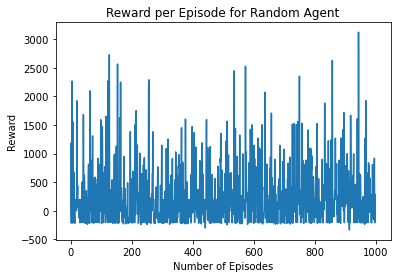

In [175]:

environment = GridWorld()
random_agent = RandomAgent()
reward_per_episode = play(environment, random_agent, rounds=1000)
plt.plot(reward_per_episode)
plt.title('Reward per Episode for Random Agent')
plt.xlabel('Number of Episodes')
plt.ylabel('Reward')

Text(0, 0.5, 'Reward')

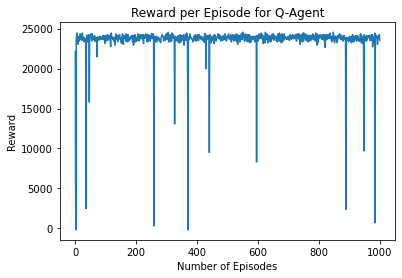

In [176]:
environment = GridWorld()
agentQ = Q_Agent(environment)
reward_per_episode = play(environment, agentQ, rounds=1000, learn=True)
plt.plot(reward_per_episode)
plt.title('Reward per Episode for Q-Agent')
plt.xlabel('Number of Episodes')
plt.ylabel('Reward')

## BELOW IS THE CODE FOR THE ATARI SECTION OF THE COURSEWORK THAT I RAN IN COLAB##

In [ ]:
from typing import Dict

from labml import monit, tracker, logger, experiment
from labml.configs import FloatDynamicHyperParam, IntDynamicHyperParam
from labml_helpers.module import Module
from labml_nn.rl.game import Worker
from labml_nn.rl.ppo import ClippedPPOLoss, ClippedValueFunctionLoss
from labml_nn.rl.ppo.gae import GAE

import numpy as np
import torch
from torch import nn
from torch import optim
from torch.distributions import Categorical



In [177]:
#starting with the model 
class Model(Module):

    def __init__(self):
        super().__init__()

#each round it takes a frame and makes a smaller frame 
#we want a flattened outcome
        self.round1 = nn.Round2d(in_channels=4, out_channels=32, kernel_size=8, stride=4)
        self.round2 = nn.Round2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.round3 = nn.Round2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)

#thris round should be flat, and have 512 features
        self.line = nn.Linear(in_features=7 * 7 * 64, out_features=512)
        self.pi_logits = nn.Linear(in_features=512, out_features=4)
        self.value = nn.Linear(in_features=512, out_features=1)
        self.activation = nn.ReLU()

    def forward(self, observation: torch.Tensor):
        h = self.activate(self.round1(observation))
        h = self.activate(self.round2(h))
        h = self.activate(self.round3(h))
        h = h.reshape((-1, 7 * 7 * 64))

        h = self.activate(self.line(h))

        pi = Categorical(logits=self.pi_logits(h))
        value = self.value(h).reshape(-1)

        return pi, value

#observations from (0,1) to (0,255)
    
def observation_to_torch(observation: np.ndarray) -> torch.Tensor:
    return torch.tensor(observation, dtype=torch.float32, device=device) / 255.


#we need a trainer

class Trainer:

    def __init__(self, *,
                 updates: int, epochs: IntDynamicHyperParam,
                 n_workers: int, worker_steps: int, batches: int,
                 value_loss_coef: FloatDynamicHyperParam,
                 entropy_bonus_coef: FloatDynamicHyperParam,
                 clipping_range: FloatDynamicHyperParam,
                 learning_rate: FloatDynamicHyperParam,
                 ):

#now we onfigure, number of updates, number of epochs to train the model with sampled data, number of worker processes,number of steps to run on each process for a single update, number of mini batches, total number of samples for a single update and size of a mini batch

        self.updates = updates
        self.epochs = epochs
        self.n_workers = n_workers
        self.worker_steps = worker_steps
        self.batches = batches
        self.batch_size = self.n_workers * self.worker_steps
        
        self.mini_batch_size = self.batch_size // self.batches
        assert (self.batch_size % self.batches == 0)

        
# Coefficients
        self.co_value_loss = co_value_loss
        self.co_entropy_bonus = co_entropy_bonus

#need a clipping range and in ppo
        self.clipping_range = clipping_range
        self.learning_rate = learning_rate

#now we're ready to initialose 

        self.workers = [Worker(47 + i) for i in range(self.n_workers)]

# we need to initialise tensors (for observations)
        self.observation = np.zeros((self.n_workers, 4, 84, 84), dtype=np.uint8)
        for worker in self.workers:
            worker.child.send(("reset", None))
        for i, worker in enumerate(self.workers):
            self.observation[i] = worker.child.recv()

#model
        self.model = Model().to(device)

#optimiser
        self.optimizer = optim.Adam(self.model.parameters(), lr=2.5e-4)

#generalised advantage estimate (gae) with gamma = 0.9 and lambda = 0.9
        self.gae = gae(self.n_workers, self.worker_steps, 0.9, 0.9)

 #clipped loss
        self.clipped_loss = ClippedPPOLoss()

#value Loss
        self.value_loss = ClippedValueFunctionLoss()
    
    
#lets sample data with our current policy

    def sample(self) -> Dict[str, torch.Tensor]:
    
        rewards = np.zeros((self.n_workers, self.worker_steps), dtype=np.float32)
        actions = np.zeros((self.n_workers, self.worker_steps), dtype=np.int32)
        done = np.zeros((self.n_workers, self.worker_steps), dtype=np.bool)
        observation = np.zeros((self.n_workers, self.worker_steps, 4, 84, 84), dtype=np.uint8)
        log_pis = np.zeros((self.n_workers, self.worker_steps), dtype=np.float32)
        values = np.zeros((self.n_workers, self.worker_steps + 1), dtype=np.float32)

        with torch.no_grad():
# sample from each worker
            for t in range(self.worker_steps):
# `self.observation` keeps track of the last observation from each worker,
#  which is the input for the model to sample the next action
                observation[:, t] = self.ervation
# sample actions from $\pi_{\theta_{OLD}}$ for each worker;
#  this returns arrays of size `n_workers`
                pi, v = self.model(observation_to_torch(self.observation))
                values[:, t] = v.cpu().numpy()
                a = pi.sample()
                actions[:, t] = a.cpu().numpy()
                log_pis[:, t] = pi.log_prob(a).cpu().numpy()

# run sampled actions on each worker
                for w, worker in enumerate(self.workers):
                    worker.child.send(("step", actions[w, t]))

                for w, worker in enumerate(self.workers):
# get results after executing the actions
                    self.observation[w], rewards[w, t], done[w, t], info = worker.child.recv()

# collect episode info, which is available if an episode finished;
#  this includes total reward and length of the episode -
#  look at `Game` to see how it works.
                    if info:
                        tracker.add('reward', info['reward'])
                        tracker.add('length', info['length'])

# Get value of after the final step
            _, v = self.model(observation_to_torch(self.observation))
            values[:, self.worker_steps] = v.cpu().numpy()

# calculate advantages
        advantages = self.gae(done, rewards, values)

    
        samples = {
            'observation': observation,
            'actions': actions,
            'values': values[:, :-1],
            'log_pis': log_pis,
            'advantages': advantages
        }

# samples are currently in `[workers, time_step]` table,
# we should flatten it for training
        samples_flat = {}
        for k, v in samples.items():
            v = v.reshape(v.shape[0] * v.shape[1], *v.shape[2:])
            if k == 'observation':
                samples_flat[k] = observation_to_torch(v)
            else:
                samples_flat[k] = torch.tensor(v, device=device)

        return samples_flat

    def train(self, samples: Dict[str, torch.Tensor]):


#learns faster with a higher number of epochs 

        for _ in range(self.epochs()):
# shuffle for each epoch
            indexes = torch.randperm(self.batch_size)

#mini batches
            for start in range(0, self.batch_size, self.mini_batch_size):
                end = start + self.mini_batch_size
                mini_batch_indexes = indexes[start: end]
                mini_batch = {}
                for k, v in samples.items():
                    mini_batch[k] = v[mini_batch_indexes]


# train
                loss = self._calc_loss(mini_batch)

# Set learning rate
                for pg in self.optimizer.param_groups:
                    pg['lr'] = self.learning_rate()
            
# Calculate and clip gradients
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
                self.optimizer.step()



#we need to normalise the funciton

  
    def _normalize(adv: torch.Tensor):
        return (adv - adv.mean()) / (adv.std() + 1e-8)
    
    
#now we define and calculate total loss
    def _calc_loss(self, samples: Dict[str, torch.Tensor]) -> torch.Tensor:
        
        sampled_return = samples['values'] + samples['advantages']
        sampled_normalized_advantage = self._normalize(samples['advantages'])

        # Sampled observations are fed into the model to get $\pi_\theta(a_t|s_t)$ and $V^{\pi_\theta}(s_t)$;
        #  we are treating observations as state
        pi, value = self.model(samples['observation'])
        log_pi = pi.log_prob(samples['actions'])

# Calculate policy loss and entropy 
        policy_loss = self.ppo_loss(log_pi, samples['log_pis'], sampled_normalized_advantage, self.clipping_range())
        entropy_bonus = pi.entropy()
        entropy_bonus = entropy_bonus.mean()

# Calculate value function loss
        value_loss = self.value_loss(value, samples['values'], sampled_return, self.clipping_range())
        loss = (policy_loss
                + self.value_loss_coef() * value_loss
                - self.entropy_bonus_coef() * entropy_bonus)

#needed for monitoring
        approx_kl_divergence = .5 * ((samples['log_pis'] - log_pi) ** 2).mean()

#now we ass this to the tracker
        tracker.add({'policy_reward': -policy_loss,
                     'value_loss': value_loss,
                     'entropy_bonus': entropy_bonus,
                     'kl_div': approx_kl_divergence,
                     'clip_fraction': self.ppo_loss.clip_fraction})

        return loss

#now we have calculates loss we can run the training loop  
    
    def run_training_loop(self):

#using 100 episodes and add new line to screen
        tracker.set_queue('reward', 100, True)
        tracker.set_queue('length', 100, True)

        for update in monit.loop(self.updates):
            samples = self.sample()
            self.train(samples)
            tracker.save()
            
            if (update + 1) % 1_000 == 0:
                logger.log()
                
#to stop the work
    def destroy(self):
        for worker in self.workers:
            worker.child.send(("close", None))

            
#now we create PPO 

def main():
    experiment.create(name='ppo')
    configs = {
        'updates': 10000,
        'epochs': IntDynamicHyperParam(8),
        'n_workers': 8,
        'worker_steps': 128,
        'batches': 4,
        'value_loss_coef': FloatDynamicHyperParam(0.5),
        'entropy_bonus_coef': FloatDynamicHyperParam(0.01),
        'clipping_range': FloatDynamicHyperParam(0.1),
        'learning_rate': FloatDynamicHyperParam(1e-3, (0, 1e-3)),
    }

    experiment.configs(configs)

    m = Trainer(**configs)

    with experiment.start():
        m.run_training_loop()
    m.destroy()


#and now we can run it! 
if __name__ == "__main__":
    main()

NameError: name 'Module' is not defined

Sources used in this doc: 

Code from labs 3, 4, 5, 6,7,8 and 9

as well as;

https://github.com/jermwatt/RL_demo/blob/master/large_gridworld_ipythonblocks.py
https://github.com/MJeremy2017/reinforcement-learning-implementation/blob/master/GridWorld/gridWorld_Q.py
https://github.com/michaeltinsley/Gridworld-with-Q-Learning-Reinforcement-Learning-/blob/master/Gridworld.ipynb
https://github.com/coreystaten/deeprl-ppo
https://towardsdatascience.com/a-graphic-guide-to-implementing-ppo-for-atari-games-5740ccbe3fbc
https://slm-lab.gitbook.io/slm-lab/using-slm-lab/search-spec-ppo-on-breakout
https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/rl/ppo/experiment.py
https://github.com/breadbread1984/Atari-PPO
https://colab.research.google.com/github/lab-ml/nn/blob/master/labml_nn/rl/ppo/experiment.ipynb
